In [1]:
%load_ext lab_black

In [2]:
def preprocess_data(df):
    df.columns = df.columns.str.lower()
    df.date = pd.to_datetime(df.date)
    df.index = df.date
    df = df[["open"]].sort_index()
    df.open = pd.to_numeric(df.open.str.replace(",", ""))
    return df

## SP500 & Nasdaq forecast

In [17]:
import pandas as pd
from datetime import timedelta, date

import numpy as np
import scipy.optimize
from matplotlib import pyplot as plt

# import pylab as plt
from scipy.stats import norm

In [18]:
sp500m = pd.read_csv("spx_monthly_yahoo.csv", sep=";")
nasdaqm = pd.read_csv("nasdaq_monthly_yahoo.csv", sep=";")

sp500m = preprocess_data(sp500m)
nasdaqm = preprocess_data(nasdaqm)

for m in [1, 3, 6, 12, 24]:
    sp500m[f"rel{m}"] = (sp500m.open / sp500m.open.shift(m)) - 1
    # sp500m[f"rel{m}_mean"] = (
    #     sp500m[f"rel{m}"].rolling(timedelta(weeks=int(4.2 * m))).mean()
    # )
    nasdaqm[f"rel{m}"] = (nasdaqm.open / nasdaqm.open.shift(m)) - 1
    # nasdaqm[f"rel{m}_mean"] = (
    #     nasdaqm[f"rel{m}"].rolling(timedelta(weeks=int(4.2 * m))).mean()
    # )

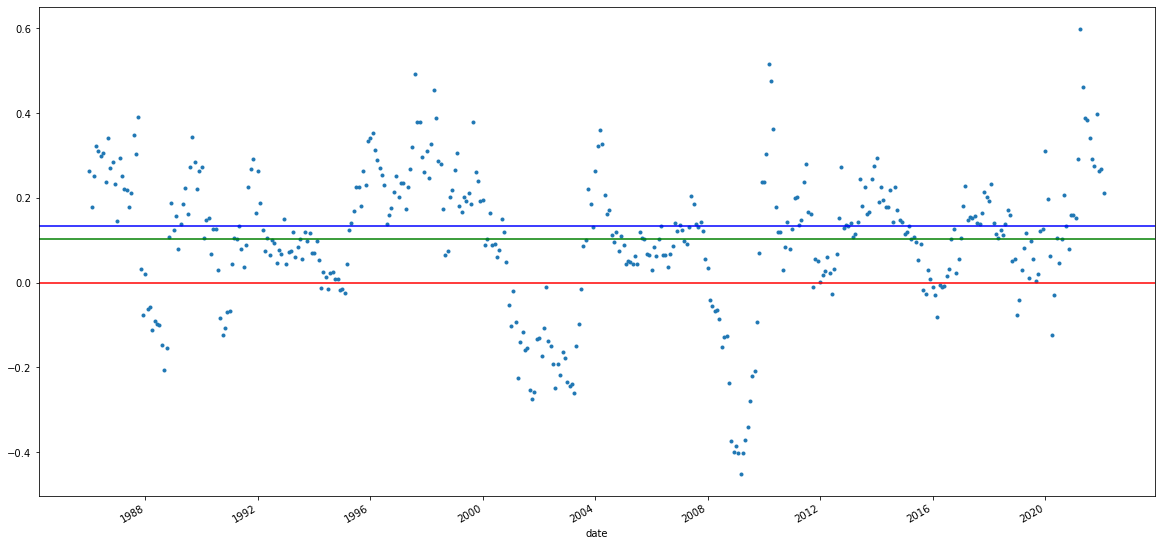

In [19]:
fig = plt.figure(figsize=(20, 10))

sp500m.rel12.plot(marker=".", linestyle="none")
plt.axhline(y=0, color="r", linestyle="-")
plt.axhline(y=sp500m.rel12.mean(), color="g", linestyle="-")
plt.axhline(y=sp500m.loc[date(2012, 1, 1) :].rel12.mean(), color="b", linestyle="-")

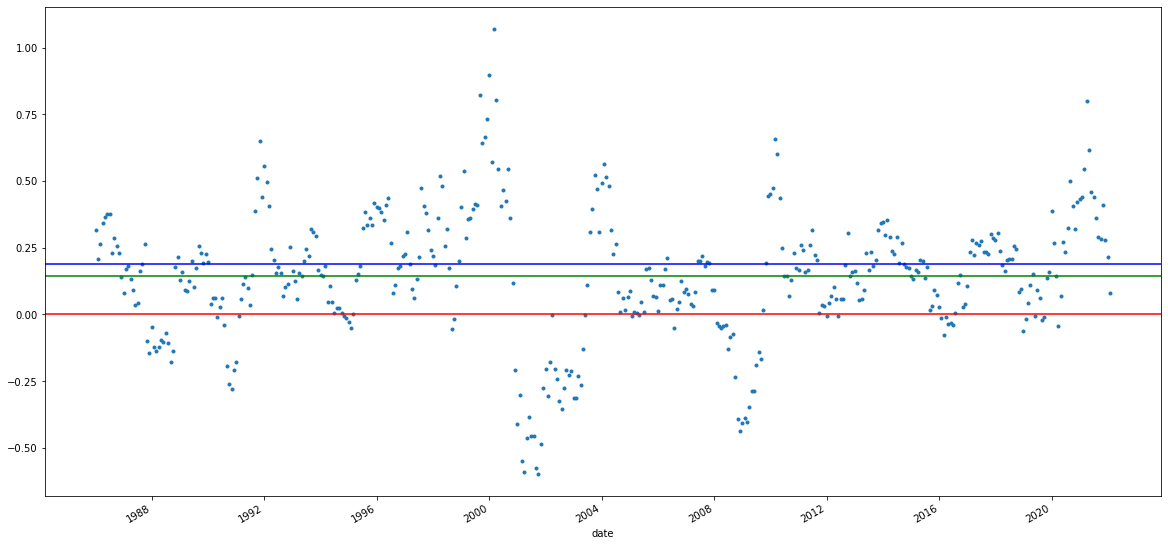

In [20]:
fig = plt.figure(figsize=(20, 10))

nasdaqm.rel12.plot(marker=".", linestyle="none")
plt.axhline(y=0, color="r", linestyle="-")
plt.axhline(y=nasdaqm.rel12.mean(), color="g", linestyle="-")
plt.axhline(y=nasdaqm.loc[date(2012, 1, 1) :].rel12.mean(), color="b", linestyle="-")

In [21]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1] - tt[0]))  # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(
        ff[numpy.argmax(Fyy[1:]) + 1]
    )  # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.0 ** 0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.0 * numpy.pi * guess_freq, 0.0, guess_offset])

    def sinfunc(t, A, w, p, c):
        return A * numpy.sin(w * t + p) + c

    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w / (2.0 * numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w * t + p) + c
    return {
        "amp": A,
        "omega": w,
        "phase": p,
        "offset": c,
        "freq": f,
        "period": 1.0 / f,
        "fitfunc": fitfunc,
        "maxcov": numpy.max(pcov),
        "rawres": (guess, popt, pcov),
    }

In [22]:
def get_proba_dist(func, x, std):
    pred_mean = func(x)

    def norm_proba_density(x):
        return norm.cdf(x=x, loc=pred_mean, scale=std)

    return norm_proba_density

In [23]:
def add_date(idx_df, x, y, y_pred, add_month=0, fit_func=None):
    """idx_df should contain x to idx mapping, x contains current x and ls is list with
    values that we would want it to be indexed with idx.

    Adds predictions for add_month.
    """
    new_y = pd.Series(y)
    new_y_pred = pd.Series(y_pred)
    new_y.index = idx_df.loc[x_sp500].date
    new_y_pred.index = idx_df.loc[x_sp500].date

    res = pd.concat([new_y.rename("y"), new_y_pred.rename("y_pred")], axis=1)

    if (add_month > 0) & (fit_func is not None):
        year = res.index.max().year
        month = res.index.max().month

        y_ext = [np.nan for m in range(add_month)]
        x_ext = np.array([x.max() + m + 1 for m in range(add_month)])
        y_pred_ext = fit_func(x_ext)

        extension = pd.DataFrame({"y": y_ext, "y_pred": y_pred_ext})
        extension.index = [
            res.index.max() + pd.DateOffset(months=m) for m in range(1, add_month + 1)
        ]
        res = pd.concat([res, extension])
    return res

In [64]:
def plot(df, start_year=None, title=None, figsize=(20, 10)):
    x = df.index
    y = df.y
    y_pred = df.y_pred

    start_prediction = y.loc[y.isna()].index[0]

    if start_year is not None:
        x = [d for d in x if d >= date(start_year, 1, 1)]
        y = y.loc[date(start_year, 1, 1) :]
        y_pred = y_pred.loc[date(start_year, 1, 1) :]

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_ylabel("return", fontsize=12)
    ax.set_xlabel("time", fontsize=12)
    ax.set_title(title, fontsize=14)

    y.plot(marker=".", linestyle="none", label="actual return", markersize=8)
    y_pred.plot(color="r", label="fitted return curve", linewidth=2)
    plt.fill_between(
        x,
        y_pred - (y_pred - y).std(),
        y_pred + (y_pred - y).std(),
        alpha=0.07,
        color="green",
        label="0-1 std, total: 68% of probability",
    )
    plt.fill_between(
        x,
        y_pred - (y_pred - y).std(),
        y_pred - 3 * (y_pred - y).std(),
        alpha=0.03,
        color="grey",
        label="1-3 std",
    )
    plt.fill_between(
        x,
        y_pred + (y_pred - y).std(),
        y_pred + 3 * (y_pred - y).std(),
        alpha=0.03,
        color="grey",
    )

    plt.axvline(start_prediction, linestyle=":", label="current_time", linewidth=3)
    plt.axvline(date(2023, 3, 1), linestyle=":", color="darkgreen")
    plt.axvline(date(2024, 3, 1), linestyle=":", color="darkgreen")
    plt.axvline(date(2025, 3, 1), linestyle=":", color="darkgreen")

    plt.legend(loc="best")
    plt.show()
    return fig

### fit sp500

In [65]:
f1 = sp500m.reset_index().dropna()

x_sp500 = f1.index
y_sp500 = f1.rel12

res_sp500 = fit_sin(x_sp500, y_sp500)
y_pred_sp500 = res_sp500["fitfunc"](x_sp500)

std = (y_pred_sp500 - y_sp500).std()

In [66]:
proba_sp500 = dict()
proba_sp500["1y"] = get_proba_dist(
    res_sp500["fitfunc"], f1.index.max() + 13, std
)  # cdf for 1 year return

proba_sp500["2y"] = get_proba_dist(
    res_sp500["fitfunc"], f1.index.max() + 25, std
)  # cdf for 1 year return

proba_sp500["3y"] = get_proba_dist(
    res_sp500["fitfunc"], f1.index.max() + 37, std
)  # cdf for 1 year return

In [67]:
proba_sp500["1y"](0)

0.47651670900530285

In [68]:
proba_sp500["2y"](0)

0.1687833966754092

In [69]:
sp_500_pred_df = add_date(
    f1, x_sp500, y_sp500, y_pred_sp500, add_month=36, fit_func=res_sp500["fitfunc"]
)

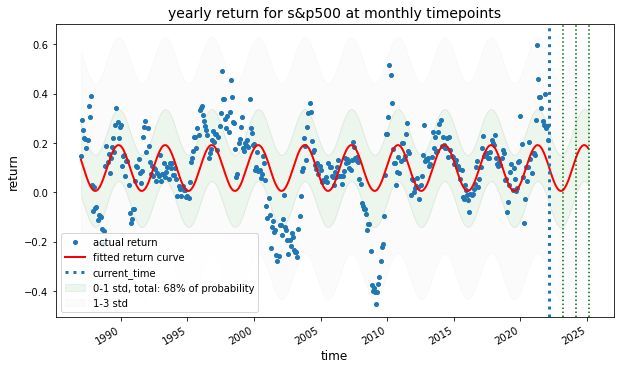

In [70]:
sp500fig = plot(
    sp_500_pred_df,
    start_year=None,
    title="yearly return for s&p500 at monthly timepoints",
    figsize=(10, 6),
)

### fit nasdaq100

In [71]:
f2 = nasdaqm.reset_index().dropna()

x_nasdaq = f2.index
y_nasdaq = f2.rel12

res_nasdaq = fit_sin(x_nasdaq, y_nasdaq)
y_pred_nasdaq = res_nasdaq["fitfunc"](x_nasdaq)

std = (y_pred_nasdaq - y_nasdaq).std()

In [72]:
proba_nasdaq = dict()

proba_nasdaq["1y"] = get_proba_dist(
    res_nasdaq["fitfunc"], f1.index.max() + 13, std
)  # cdf for 1 year return

proba_nasdaq["2y"] = get_proba_dist(
    res_nasdaq["fitfunc"], f1.index.max() + 25, std
)  # cdf for 1 year return

proba_nasdaq["3y"] = get_proba_dist(
    res_nasdaq["fitfunc"], f1.index.max() + 37, std
)  # cdf for 1 year return

In [73]:
proba_nasdaq["1y"](0)

0.5492351331591886

In [74]:
proba_nasdaq["2y"](0)

0.18283520612823018

In [75]:
nasdaq_pred_df = add_date(
    f2, x_nasdaq, y_nasdaq, y_pred_nasdaq, add_month=36, fit_func=res_nasdaq["fitfunc"]
)

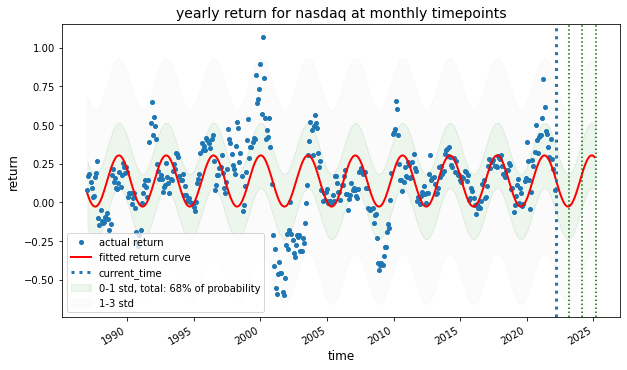

In [76]:
nasfig = plot(
    nasdaq_pred_df,
    start_year=None,
    title="yearly return for nasdaq at monthly timepoints",
    figsize=(10, 6),
)

In [77]:
nasfig.savefig("forecast_nasdaq.png")

## get probability estimates

In [334]:
thresholds = {
    "bad_return": (-np.inf, -0.02),
    "neutral_return": (-0.02, 0.05),
    "good_return": (0.05, np.inf),
}

In [349]:
def print_probas(d, thresholds):
    for i, (k, f) in enumerate(d.items()):
        print(k, f",that is one year return at march 20{23+i}")
        for cat, t in thresholds.items():
            print(f"{cat}: {f(t[1]) - f(t[0]):.2f}")
        print()

In [350]:
print_probas(proba_sp500, thresholds)

1y ,that is one year return at march 2023
bad_return: 0.42
neutral_return: 0.19
good_return: 0.39

2y ,that is one year return at march 2024
bad_return: 0.14
neutral_return: 0.13
good_return: 0.73

3y ,that is one year return at march 2025
bad_return: 0.09
neutral_return: 0.11
good_return: 0.80



In [351]:
print_probas(proba_nasdaq, thresholds)

1y ,that is one year return at march 2023
bad_return: 0.51
neutral_return: 0.13
good_return: 0.36

2y ,that is one year return at march 2024
bad_return: 0.16
neutral_return: 0.09
good_return: 0.75

3y ,that is one year return at march 2025
bad_return: 0.07
neutral_return: 0.06
good_return: 0.87

